In [1]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import matplotlib.pyplot as plt
import torchvision.models as models             

              # for example model
from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           # turn on actually quantization, like FP32 -> INT8
from copy import deepcopy

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True).cuda()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x0_5", pretrained=True).cuda()

Using cache found in /home/zihao/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [2]:
train,test = get_loader('cifar10'.upper(),batch_size=128,test_batch_size=128)
train.num_workers = 2
test.num_workers = 2
train.pin_in_memory = True
test.pin_in_memory = True

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
i = 0
for img,label in train:
    i += 1
    calib_data.append((img,label))
    if i == 8:
        break

In [4]:
MPQ_scheme = (2,4,8)

model.eval()
torch_fp_model = deepcopy(model)
torch_mix_model = deepcopy(model)
for b in MPQ_scheme:
    exec(f'torch_{b}bits_model=deepcopy(model)')

In [5]:
def getModuleByName(modelName,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    eval_str = modelName
    for token in tokens:
        try:
            eval_str += f'[{int(token)}]'
        except:
            eval_str += f'.{token}'

    return eval(eval_str)

for b in MPQ_scheme:
    
    mqb_model = deepcopy(model)
    # MSE calibration on model parameters
    backend = BackendType.Academic
    extra_config = {
        'extra_qconfig_dict': {
            'w_observer': 'MSEObserver',                              # custom weight observer
            'a_observer': 'EMAMSEObserver',                              # custom activation observer
            'w_fakequantize': 'FixedFakeQuantize',                    # custom weight fake quantize function
            'a_fakequantize': 'FixedFakeQuantize',                    # custom activation fake quantize function
            'w_qscheme': {
                'bit': b,                                             # custom bitwidth for weight,
                'symmetry': True,                                    # custom whether quant is symmetric for weight,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
                'pot_scale': False,                                   # custom whether scale is power of two for weight.
            },
            'a_qscheme': {
                'bit': 8,                                             # custom bitwidth for activation,
                'symmetry': False,                                    # custom whether quant is symmetric for activation,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
                'pot_scale': False,                                   # custom whether scale is power of two for activation.
            }
        }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
    }
    print(f'Prepare {b}bits model using MQBench')

    mqb_model = prepare_by_platform(mqb_model, backend,extra_config).cuda()
    
    # calibration loop
    enable_calibration(mqb_model)
    for img,label in calib_data:
        mqb_model(img.cuda())  

    # evaluation loop
    enable_quantization(mqb_model)
    print('evaluate mqb quantized model')
    evaluate(test,mqb_model)

    # pass quantized weight to torch_quantized_model
    for n,m in mqb_model.named_modules():
        if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
            # print('loading quantized weight for layer',n)
            torch_module = getModuleByName(f'torch_{b}bits_model',n)
            torch_module.weight.data = m.weight_fake_quant(m.weight).data

Prepare 2bits model using MQBench
[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 2 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
[MQBENCH] INFO: Set x post act quantize to 8 bit.
[MQBENCH] INFO: Insert act quant x_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant 

[MQBENCH] INFO: Insert act quant layer2_8_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_1_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_1_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_2_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_2_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_3_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_3_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_4_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_4_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_5_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_5_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_6_relu_post_act_fake_qu

In [6]:
evaluate(test,torch_8bits_model) 

{'mean_acc': 0.9428,
 'qtl_acc': 0.9428,
 'mean_loss': 0.25467106251965593,
 'qtl_loss': 0.25467106251965593,
 'test time': 1.6306531429290771,
 'acc_list': array([0.9428]),
 'loss_list': array([0.25467106])}

In [7]:
mqb_model = None

## FeintLady

In [8]:
from collections import OrderedDict
# 1. record all modules we want to consider
layers_to_quant = OrderedDict() # layer_name:[torch_fp_module,torch_q_module,torch_p_module]
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

for n,m in torch_fp_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n] = {'fp':m}

for b in MPQ_scheme:
    for n,m in eval(f'torch_{b}bits_model').named_modules():
        if isinstance(m,types_to_quant):
            layers_to_quant[n][f'{b}bits'] = m

for n,m in torch_mix_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n]['mix'] = m

In [9]:
res = evaluate(calib_data,torch_fp_model)
ref_metric = ('mean_loss',res['mean_loss'])

In [10]:
res

{'mean_acc': 1.0,
 'qtl_acc': 1.0,
 'mean_loss': 0.0012430445276550017,
 'qtl_loss': 0.0012430445276550017,
 'test time': 0.14760684967041016,
 'acc_list': array([1.]),
 'loss_list': array([0.00124304])}

In [11]:
def perturb_loss(perturb_scheme,ref_metric,eval_data,mix_perturb=False,printInfo=False):
    # perturb_schemes: dictionary of {layer_name: bitwidth}
    # mix_perturb: if true, perturb_schemes {layer_name:(bitwidth1,bitwidth2)}
    
    with torch.no_grad():
        # perturb layers
        if not mix_perturb:
            for n in perturb_scheme:
                b = perturb_scheme[n]
                layers_to_quant[n]['mix'].weight.data = layers_to_quant[n][f'{b}bits'].weight.data
        else:
            # mix perturbation
            for n in perturb_scheme:
                b1,b2 = perturb_scheme[n]
                d1 = layers_to_quant[n][f'{b1}bits'].weight.data - layers_to_quant[n]['fp'].weight.data
                d2 = layers_to_quant[n][f'{b2}bits'].weight.data - layers_to_quant[n]['fp'].weight.data
                layers_to_quant[n]['mix'].weight.data = layers_to_quant[n]['fp'].weight.data + 0.5*d1 + 0.5*d2
            
        # do evaluation
        res = evaluate(eval_data,torch_mix_model)
        perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        
        if printInfo:
            print(res)
        # recover layers
        for n in perturb_scheme:
            layers_to_quant[n]['mix'].weight.data = layers_to_quant[n]['fp'].weight.data
    return perturbed_loss

In [12]:
layers_to_quant

OrderedDict([('conv1',
              {'fp': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               '2bits': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               '4bits': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               '8bits': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               'mix': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)}),
             ('layer1.0.conv1',
              {'fp': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               '2bits': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               '4bits': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               '8bits': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
               'mix': Conv2d(

## Build Cached Grad if not done before

In [ ]:
import time
s_time = time.time()
cached = {}
for n in layers_to_quant:
    for m in layers_to_quant:
        for s1 in MPQ_scheme:
            for s2 in MPQ_scheme:
                if (n,m,s1,s2) not in cached:
                    if n == m:
                        print(f'mix perturb layer {n} to {s1}bits and {s2}bits')
                        p = perturb_loss({n:(s1,s2)},ref_metric,calib_data,mix_perturb=True)
                    else:
                        print(f'perturb layer {n} to {s1}bits and layer {m} to {s2}bits')
                        p = perturb_loss({n:s1,m:s2},ref_metric,calib_data,mix_perturb=False)
                    
                    cached[(n,m,s1,s2)] = cached[(m,n,s2,s1)] = p
                    
print(f'{time.time()-s_time:.2f} seconds elapsed')

In [ ]:
layer_index = {}
cnt = 0
for layer in layers_to_quant:
    for s in MPQ_scheme:
        layer_index[layer+f'{s}bits'] = cnt
        cnt += 1
L = cnt

In [ ]:
import numpy as np
hm = np.zeros(shape=(L,L))
for n in layers_to_quant:
    for m in layers_to_quant:
        for s1 in MPQ_scheme:
            for s2 in MPQ_scheme:
                hm[layer_index[n+f'{s1}bits'],layer_index[m+f'{s2}bits']] = cached[(n,m,s1,s2)]

In [ ]:
cached_grad = np.zeros_like(hm)

In [ ]:
import pickle
with open('generalw248_c10resnet56_calib','wb') as f:
    pickle.dump({'Ltilde':hm,'layer_index':layer_index},f)

In [ ]:
perturb_loss(['conv1',],ref_metric,eval_data=calib_data)

## Load Cached Grad

In [13]:
import pickle
with open('generalw248_c10resnet56_calib','rb') as f:
    hm = pickle.load(f)

In [14]:
index2layerscheme = [None for i in range(hm['Ltilde'].shape[0])]

for name in hm['layer_index']:
    index = hm['layer_index'][name]
    layer_name = name[:-5]
    scheme = name[-5:]
    a = hm['Ltilde']
    print(f'index {index} layer {layer_name} scheme {scheme} Ltilde {a[index,index].item():.6f}')
    
    index2layerscheme[index] = (layer_name,scheme)
    

index 0 layer conv1 scheme 2bits Ltilde 0.000084
index 1 layer conv1 scheme 4bits Ltilde 0.000084
index 2 layer conv1 scheme 8bits Ltilde 0.000084
index 3 layer layer1.0.conv1 scheme 2bits Ltilde 0.012103
index 4 layer layer1.0.conv1 scheme 4bits Ltilde -0.000006
index 5 layer layer1.0.conv1 scheme 8bits Ltilde -0.000006
index 6 layer layer1.0.conv2 scheme 2bits Ltilde 0.003898
index 7 layer layer1.0.conv2 scheme 4bits Ltilde 0.000137
index 8 layer layer1.0.conv2 scheme 8bits Ltilde -0.000007
index 9 layer layer1.1.conv1 scheme 2bits Ltilde 0.002645
index 10 layer layer1.1.conv1 scheme 4bits Ltilde 0.000249
index 11 layer layer1.1.conv1 scheme 8bits Ltilde 0.000004
index 12 layer layer1.1.conv2 scheme 2bits Ltilde 0.000970
index 13 layer layer1.1.conv2 scheme 4bits Ltilde 0.000042
index 14 layer layer1.1.conv2 scheme 8bits Ltilde 0.000004
index 15 layer layer1.2.conv1 scheme 2bits Ltilde 0.000396
index 16 layer layer1.2.conv1 scheme 4bits Ltilde 0.000011
index 17 layer layer1.2.conv1 s

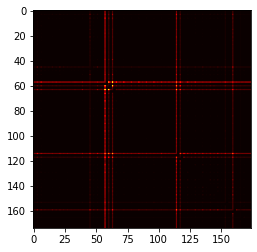

In [15]:
plt.imshow(hm['Ltilde'],cmap='hot')

In [16]:
L = hm['Ltilde'].shape[0]
cached_grad = np.zeros_like(hm['Ltilde'])
for i in range(L):
    for j in range(L):
        layer_i,scheme_i = index2layerscheme[i]
        layer_j,scheme_j = index2layerscheme[j]
        if layer_i == layer_j:
            if scheme_i == scheme_j:
                cached_grad[i,j] = cached_grad[j,i] = 2*hm['Ltilde'][i,j]
            else:
                #cached_grad[i,j] = cached_grad[j,i] = 4 * hm['Ltilde'][i,j] - hm['Ltilde'][i,i] - hm['Ltilde'][j,j]
                cached_grad[i,j] = cached_grad[j,i] = 0
        else:
            cached_grad[i,j] = cached_grad[j,i] = hm['Ltilde'][i,j] - hm['Ltilde'][i,i] - hm['Ltilde'][j,j]
        '''
        print(index2layerscheme[i])
        print(index2layerscheme[j])
        '''
        '''
        if i == j:
            cached_grad[i,j] = 0.5 * hm['Ltilde'][i,j]
        else:
            cached_grad[i,j] = 0.25 * (hm['Ltilde'][i,j]-hm['Ltilde'][i,i]-hm['Ltilde'][j,j])
        '''

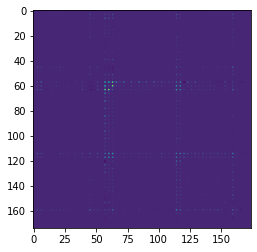

In [17]:
# cached_grad[cached_grad<0]=0
plt.imshow(cached_grad)

### Define a naive cost function: model size

In [18]:
layer_size = np.array([0 for i in range(L)])
for l in hm['layer_index']:
    index = hm['layer_index'][l]
    layer_name, scheme = index2layerscheme[index]
    layer_size[index] = torch.numel(layers_to_quant[layer_name]['fp'].weight) * int(scheme[0])

In [19]:
# initialize random variable v
# use recitfied sigmoid h(v) to represent alpha
# freg is 1-(1-2h(v))**beta, annealing beta to 

if not isinstance(cached_grad,torch.Tensor):
    cached_grad = torch.Tensor(cached_grad)

layer_size_tensor = torch.Tensor(layer_size)

def lossfunc(v,beta,lambda1,lambda2,printInfo=False,naive=False,b=None):
    
    alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme))).reshape(-1,)
    
    if not naive:
        outer_alpha = torch.outer(alpha,alpha)
        netloss = torch.sum(outer_alpha * cached_grad)
    else:
        netloss = torch.sum(torch.diagonal(cached_grad) * alpha)
        
    model_size = torch.sum(layer_size_tensor * alpha)/8/1024/1024 # model size in MB
            
    regloss = torch.sum(1-(torch.abs(1-2*alpha))**beta)
    regloss *= lambda1

    if b is None:
        closs = lambda2 * model_size
    else:
        closs = lambda2 * torch.clamp(model_size-b,0)
    
    totloss = netloss + regloss + closs
    
    if printInfo:
        print(f'netloss {netloss.item():.4f} regloss {regloss.item():.4f}(beta={beta:.4f}) closs{closs.item():.4f}(model size: {model_size.item():.4f}MB constraint:{b})')
        print('alpha:\n',alpha)
        
    return totloss    
    

In [20]:
def optimize(n_iteration,lr,beta,lambda1,lambda2,b=None,naive=False):
    
    v = torch.nn.Parameter(torch.randn(L))
    optim = torch.optim.Adam([v,],lr=lr)
    bs = np.linspace(beta[0],beta[1],n_iteration)
    
    for i in range(n_iteration):
        if i==0 or (i+1) % 1000 == 0:
            printInfo = True
            print(f'Iter {i+1}')
        else:
            printInfo = False
            
        optim.zero_grad()
        loss = lossfunc(v,bs[i],lambda1,lambda2,printInfo=printInfo,b=b,naive=naive)
        loss.backward()
        optim.step()
    
    return v

def evaluate_decision(v,printInfo=False,test=test):
    v = v.detach()
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(MPQ_scheme)),dtype=int) * len(MPQ_scheme)
    offset = offset.cumsum(dim=-1) - len(MPQ_scheme)
    select = v.reshape(-1,len(MPQ_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = index2layerscheme[scheme_id]
        decisions[layer] = scheme
    
    print("evaluate_decision\n",decisions)
    

    with torch.no_grad():
        # perturb layers
        for n in decisions:
            layers_to_quant[n]['mix'].weight.data = layers_to_quant[n][decisions[n]].weight.data
        # do evaluation
        res = evaluate(test,torch_mix_model)
        # recover layers
        for n in decisions:
            layers_to_quant[n]['mix'].weight.data = layers_to_quant[n]['fp'].weight.data
    return res,modelsize

In [21]:
v = optimize(n_iteration=5000,lr=2e-3,beta=[20,2],lambda1=1e-6,lambda2=1e-4,naive=True)

Iter 1
netloss 0.6911 regloss 0.0002(beta=20.0000) closs0.0000(model size: 0.4736MB constraint:None)
alpha:
 tensor([0.1722, 0.1587, 0.6691, 0.0627, 0.1411, 0.7962, 0.4473, 0.5238, 0.0289,
        0.2566, 0.2157, 0.5277, 0.1885, 0.3004, 0.5112, 0.0847, 0.6187, 0.2966,
        0.4508, 0.0645, 0.4846, 0.0543, 0.3307, 0.6150, 0.5195, 0.3295, 0.1510,
        0.1404, 0.5901, 0.2695, 0.5122, 0.3652, 0.1226, 0.0477, 0.4605, 0.4918,
        0.3387, 0.1416, 0.5197, 0.6802, 0.1125, 0.2073, 0.2786, 0.3792, 0.3422,
        0.2593, 0.4515, 0.2891, 0.6413, 0.1747, 0.1841, 0.5059, 0.2548, 0.2393,
        0.0420, 0.0346, 0.9234, 0.3820, 0.2668, 0.3512, 0.1562, 0.3188, 0.5249,
        0.0869, 0.6510, 0.2622, 0.2293, 0.3770, 0.3937, 0.4202, 0.2173, 0.3625,
        0.2648, 0.6061, 0.1291, 0.8855, 0.0742, 0.0403, 0.4288, 0.2275, 0.3438,
        0.1139, 0.3179, 0.5682, 0.8340, 0.0641, 0.1019, 0.6843, 0.2707, 0.0450,
        0.3072, 0.5146, 0.1782, 0.9326, 0.0238, 0.0436, 0.2090, 0.5576, 0.2334,
        0.2

Iter 4000
netloss 0.0053 regloss 0.0000(beta=5.6007) closs0.0001(model size: 0.6517MB constraint:None)
alpha:
 tensor([3.8150e-04, 1.2425e-04, 9.9949e-01, 5.9828e-04, 1.4933e-01, 8.5007e-01,
        1.1189e-03, 6.1173e-02, 9.3771e-01, 2.0628e-03, 4.4511e-03, 9.9349e-01,
        1.3773e-03, 1.0889e-02, 9.8773e-01, 4.8499e-04, 7.7631e-03, 9.9175e-01,
        3.7616e-03, 6.3589e-02, 9.3265e-01, 4.1144e-04, 6.8326e-03, 9.9276e-01,
        2.3824e-03, 1.9964e-02, 9.7765e-01, 9.8536e-04, 9.9470e-01, 4.3144e-03,
        8.4366e-04, 9.9849e-01, 6.6233e-04, 2.7305e-04, 9.7145e-01, 2.8276e-02,
        2.0192e-03, 7.5583e-01, 2.4215e-01, 4.2165e-03, 9.6236e-03, 9.8616e-01,
        1.6152e-03, 1.9647e-02, 9.7874e-01, 1.5112e-03, 5.0280e-02, 9.4821e-01,
        4.7253e-03, 2.5283e-01, 7.4245e-01, 3.3857e-03, 1.1987e-01, 8.7675e-01,
        2.5021e-04, 9.9152e-01, 8.2336e-03, 3.3440e-03, 4.3145e-01, 5.6520e-01,
        1.3239e-03, 1.2923e-01, 8.6945e-01, 5.9748e-04, 2.0964e-01, 7.8976e-01,
        1

In [22]:
evaluate_decision(v)

evaluate_decision
 {'conv1': '8bits', 'layer1.0.conv1': '8bits', 'layer1.0.conv2': '8bits', 'layer1.1.conv1': '8bits', 'layer1.1.conv2': '8bits', 'layer1.2.conv1': '8bits', 'layer1.2.conv2': '8bits', 'layer1.3.conv1': '8bits', 'layer1.3.conv2': '8bits', 'layer1.4.conv1': '4bits', 'layer1.4.conv2': '4bits', 'layer1.5.conv1': '4bits', 'layer1.5.conv2': '4bits', 'layer1.6.conv1': '8bits', 'layer1.6.conv2': '8bits', 'layer1.7.conv1': '8bits', 'layer1.7.conv2': '8bits', 'layer1.8.conv1': '8bits', 'layer1.8.conv2': '4bits', 'layer2.0.conv1': '8bits', 'layer2.0.conv2': '8bits', 'layer2.0.downsample.0': '8bits', 'layer2.1.conv1': '8bits', 'layer2.1.conv2': '4bits', 'layer2.2.conv1': '8bits', 'layer2.2.conv2': '4bits', 'layer2.3.conv1': '8bits', 'layer2.3.conv2': '8bits', 'layer2.4.conv1': '8bits', 'layer2.4.conv2': '4bits', 'layer2.5.conv1': '4bits', 'layer2.5.conv2': '2bits', 'layer2.6.conv1': '8bits', 'layer2.6.conv2': '4bits', 'layer2.7.conv1': '4bits', 'layer2.7.conv2': '8bits', 'layer2.8.

({'mean_acc': 0.9362,
  'qtl_acc': 0.9362,
  'mean_loss': 0.29583423400792896,
  'qtl_loss': 0.29583423400792896,
  'test time': 1.5705959796905518,
  'acc_list': array([0.9362]),
  'loss_list': array([0.29583423])},
 0.6720733642578125)

## Use only 4 and 8 bits

In [ ]:
MPQ_scheme = (2,4,8)

In [ ]:
cached_grad.size()

In [ ]:
del_index = []
for index in range(len(index2layerscheme)):
    if (int(index2layerscheme[index][1][:-4])) not in MPQ_scheme:
        del_index.append(index)

In [ ]:
cached_grad = np.delete(cached_grad,[del_index],axis=0)
cached_grad = np.delete(cached_grad,[del_index],axis=1)
index2layerscheme = np.delete(index2layerscheme,[del_index],axis=0)
layer_size = np.delete(layer_size,[del_index],axis=0)

In [ ]:
L = len(layer_size)

In [ ]:
L

In [ ]:
if not isinstance(cached_grad,torch.Tensor):
    cached_grad = torch.Tensor(cached_grad)

layer_size_tensor = torch.Tensor(layer_size)

def lossfunc(v,beta,lambda1,lambda2,printInfo=False,naive=False,b=None):
    
    alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme))).reshape(-1,)
    
    if not naive:
        outer_alpha = torch.outer(alpha,alpha)
        netloss = torch.sum(outer_alpha * cached_grad)
    else:
        netloss = torch.sum(torch.diagonal(cached_grad) * alpha)
        
    model_size = torch.sum(layer_size_tensor * alpha)/8/1024/1024 # model size in MB
            
    regloss = torch.sum(1-(torch.abs(1-2*alpha))**beta)
    regloss *= lambda1

    if b is None:
        closs = lambda2 * model_size
    else:
        closs = lambda2 * torch.clamp(model_size-b,0)
    
    totloss = netloss + regloss + closs
    
    if printInfo:
        print(f'netloss {netloss.item():.4f} regloss {regloss.item():.4f}(beta={beta:.4f}) closs{closs.item():.4f}(model size: {model_size.item():.4f}MB constraint:{b})')
        print('alpha:\n',alpha)
        
    return totloss    

In [ ]:
def optimize(n_iteration,lr,beta,lambda1,lambda2,b=None,naive=False):
    
    v = torch.nn.Parameter(torch.randn(L))
    optim = torch.optim.Adam([v,],lr=lr)
    bs = np.linspace(beta[0],beta[1],n_iteration)
    
    for i in range(n_iteration):
        if i==0 or (i+1) % 1000 == 0:
            printInfo = True
            print(f'Iter {i+1}')
        else:
            printInfo = False
            
        optim.zero_grad()
        loss = lossfunc(v,bs[i],lambda1,lambda2,printInfo=printInfo,b=b,naive=naive)
        loss.backward()
        optim.step()
    
    return v

def evaluate_decision(v,printInfo=False,test=test):
    v = v.detach()
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(MPQ_scheme)),dtype=int) * len(MPQ_scheme)
    offset = offset.cumsum(dim=-1) - len(MPQ_scheme)
    select = v.reshape(-1,len(MPQ_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = index2layerscheme[scheme_id]
        decisions[layer] = scheme
    
    print("evaluate_decision\n",decisions)
    

    with torch.no_grad():
        # perturb layers
        for n in decisions:
            layers_to_quant[n]['mix'].weight.data = layers_to_quant[n][decisions[n]].weight.data
        # do evaluation
        res = evaluate(test,torch_mix_model)
        # recover layers
        for n in decisions:
            layers_to_quant[n]['mix'].weight.data = layers_to_quant[n]['fp'].weight.data
    return res,modelsize

## Random MPQ

In [ ]:
# random_size = []
# random_acc = []
for i in range(500):
    v = torch.randn(L)
    res,size = evaluate_decision(v)
    random_size.append(size)
    random_acc.append(res['mean_acc'])

In [ ]:
random_size,random_acc

In [ ]:
with open('resnet56_random_baseline.pkl','wb') as f:
    pickle.dump({'size':random_size,'acc':random_acc},f)
    

In [ ]:
plt.hist(random_size)

## Pareto-Frontier of FeintLady vs Inter-Layer Dependency Unaware Optimization (Naive)

In [ ]:
n_iters = (5000,10000)
lambda1s = np.logspace(-6,-3,3)
lambda2s = np.logspace(-3,1,50) 
sample_size = 5
results = {}
for n_iter in n_iters:
    for lambda1 in lambda1s:
        for lambda2 in lambda2s:
            feint_loss,feint_size = [],[]
            trial_name = f'{MPQ_scheme}bits_CLADO_lambda1{lambda1}_lambda2{lambda2}_{n_iter}iters'
            print(trial_name)
            for repeat in range(sample_size):
                v = optimize(n_iteration=n_iter,lr=2e-3,beta=[20,2],lambda1=lambda1,lambda2=lambda2,naive=False)
                perf,size = evaluate_decision(v)
                feint_loss.append(perf)
                feint_size.append(size)
            results[trial_name] = {'size':feint_size,'perf':feint_loss}

In [ ]:
results

In [ ]:
n_iters = (5000,10000)
lambda1s = np.logspace(-6,-3,3)
lambda2s = np.logspace(-6,-1,50) #lambda1=1e-3,n=5000,lr=1e-3,beta=[20,2] for resnet20 on cifar10
sample_size = 5

for n_iter in n_iters:
    for lambda1 in lambda1s:
        for lambda2 in lambda2s:
            naive_loss,naive_size = [],[]
            print('lambda2:',lambda2)
            trial_name = f'{MPQ_scheme}bits_NAIVE_lambda1{lambda1}_lambda2{lambda2}_{n_iter}iters'
            for repeat in range(sample_size):
                v = optimize(n_iteration=n_iter,lr=2e-3,beta=[20,2],lambda1=lambda1,lambda2=lambda2,naive=True)
                perf,size = evaluate_decision(v)
                naive_loss.append(perf)
                naive_size.append(size)
            results[trial_name] = {'size':naive_size,'perf':naive_loss}

In [ ]:
with open('general248c10resnet56results.pkl','wb') as f:
    pickle.dump(results,f)

In [36]:
with open('saved/general48c10resnet56results.pkl','rb') as f:
    c48 = pickle.load(f)
with open('saved/general248c10resnet56results.pkl','rb') as f:
    c248 = pickle.load(f)

In [37]:
def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys
plt.rcParams['figure.figsize'] = (12,8)

(0.88, 0.95)

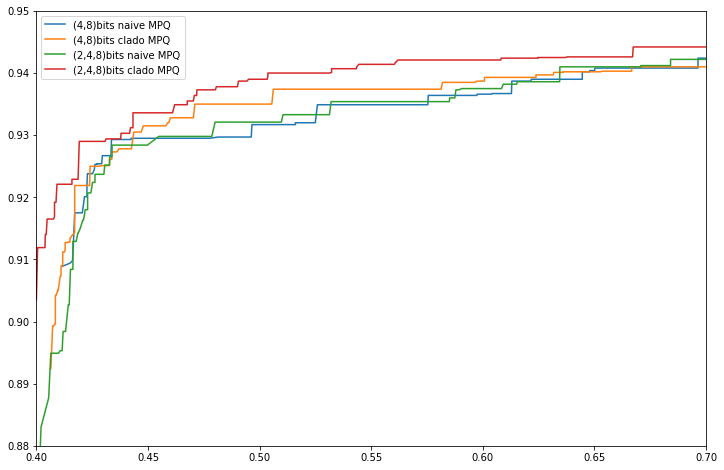

In [42]:
clado_size,clado_acc = [], []
naive_size,naive_acc = [], []
for trial in c48:
    size = c48[trial]['size']
    perf = c48[trial]['perf']
    perf = [x['mean_acc'] for x in perf]
    if 'NAIVE' in trial:
        naive_size,naive_acc = naive_size+size,naive_acc+perf
    if 'CLADO' in trial:
        clado_size,clado_acc = clado_size+size,clado_acc+perf 
    #size = np.array(size)
    #perf = np.array(perf)
    #size,perf = getPF(size,perf)
    #plt.plot(size,perf,label=trial)
c48_naive_pf = getPF(np.array(naive_size),np.array(naive_acc))
c48_clado_pf = getPF(np.array(clado_size),np.array(clado_acc))
plt.plot(c48_naive_pf[0],c48_naive_pf[1],label='(4,8)bits naive MPQ')
plt.plot(c48_clado_pf[0],c48_clado_pf[1],label='(4,8)bits clado MPQ')

clado_size,clado_acc = [], []
naive_size,naive_acc = [], []
for trial in c248:
    size = c248[trial]['size']
    perf = c248[trial]['perf']
    perf = [x['mean_acc'] for x in perf]
    if 'NAIVE' in trial:
        naive_size,naive_acc = naive_size+size,naive_acc+perf
    if 'CLADO' in trial:
        clado_size,clado_acc = clado_size+size,clado_acc+perf 
    #size = np.array(size)
    #perf = np.array(perf)
    #size,perf = getPF(size,perf)
    #plt.plot(size,perf,label=trial)
c248_naive_pf = getPF(np.array(naive_size),np.array(naive_acc))
c248_clado_pf = getPF(np.array(clado_size),np.array(clado_acc))
plt.plot(c248_naive_pf[0],c248_naive_pf[1],label='(2,4,8)bits naive MPQ')
plt.plot(c248_clado_pf[0],c248_clado_pf[1],label='(2,4,8)bits clado MPQ')
plt.legend()

plt.xlim([0.4,0.7])
plt.ylim([0.88,0.95])

In [ ]:
c48_naive_size = np.array(c48['naive_size'])
c48_naive_loss = c48['naive_loss']
c48_feint_size = np.array(c48['feint_size'])
c48_feint_loss = c48['feint_loss']

c48_naive_acc = []
for i in range(len(c48_naive_loss)):
    c48_naive_acc.append(c48_naive_loss[i]['mean_acc'])

c48_feint_acc = []
for i in range(len(c48_feint_loss)):
    c48_feint_acc.append(c48_feint_loss[i]['mean_acc'])

c248_naive_size = np.array(c248['naive_size'])
c248_naive_loss = c248['naive_loss']
c248_feint_size = np.array(c248['feint_size'])
c248_feint_loss = c248['feint_loss']

c248_naive_acc = []
for i in range(len(c248_naive_loss)):
    c248_naive_acc.append(c248_naive_loss[i]['mean_acc'])

c248_feint_acc = []
for i in range(len(c248_feint_loss)):
    c248_feint_acc.append(c248_feint_loss[i]['mean_acc'])

In [ ]:
def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys

plt.rcParams["figure.figsize"] = (12,10)

c48_feint_size,c48_feint_acc = getPF(c48_feint_size,c48_feint_acc)

c48_naive_size,c48_naive_acc = getPF(c48_naive_size,c48_naive_acc)

c248_feint_size,c248_feint_acc = getPF(c248_feint_size,c248_feint_acc)

c248_naive_size,c248_naive_acc = getPF(c248_naive_size,c248_naive_acc)

plt.scatter(c48_naive_size,c48_naive_acc,color='lightcoral',alpha=0.5,label='c48 Inter-Layer Depedency Unaware Optimization')
plt.scatter(c48_feint_size,c48_feint_acc,color='lightblue',alpha=0.5,label='c48 FeintLady Optimization')
# plt.scatter(c248_naive_size,c248_naive_acc,color='red',alpha=0.5,label='c248 CLADO Used')
# plt.scatter(c248_feint_size,c248_feint_acc,color='blue',alpha=0.5,label='c248 CLADO Not Used')

plt.xlabel('Hardware cost')
plt.ylabel('Performance')
plt.legend()
#plt.savefig('c100resnet56FeintEffecacy.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.scatter(naive_size,naive_acc,color='red',alpha=0.5,label='naive')
# plt.scatter(naive_size,naive_acc,color='blue',alpha=0.5,label='feint')
plt.xlabel('hardware cost')
plt.ylabel('performance')
plt.legend()
plt.show()

## Visualization

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

fname = 'result_cifar100_shufflenetv2_x2_0_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_sfn20 = pickle.load(f)

fname = 'result_cifar100_shufflenetv2_x1_5_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_sfn15 = pickle.load(f)
    
fname = 'result_cifar100_mobilenetv2_x1_4_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_mbn14 = pickle.load(f)

fname = 'result_cifar100_mobilenetv2_x0_75_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_mbn075 = pickle.load(f)
    

fname = 'result_cifar100_resnet56_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_rsn56 = pickle.load(f)
    
    

In [ ]:
for k in res_rsn56: print(k)

In [ ]:
def getPF_(xs,ys,mode='max',roundtoprecision=1):
    pf = {}
    for x,y in zip(xs,ys):
        new_x = round(x,roundtoprecision)
        if new_x in pf:
            pf[new_x] = eval(mode)(pf[new_x],y)
        else:
            pf[new_x] = y
    
    pf_x,pf_y = [],[]
    
    for x in pf:
        pf_x.append(x)
        pf_y.append(pf[x])
    
    pf_x, pf_y = np.array(pf_x),np.array(pf_y)
    
    return pf_x,pf_y

def getPF(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    order = np.argsort(xs)
    
    xs = xs[order]
    ys = ys[order]
    
    cur_max = -1
    for i in range(ys.shape[0]):
        if ys[i] > cur_max:
            cur_max = ys[i]
        ys[i] = cur_max
    
    return xs,ys
        

In [ ]:

x_1_mbn075,y_1_mbn075 = getPF(res_mbn075['naive_size'],res_mbn075['naive_acc'])
x_2_mbn075,y_2_mbn075 = getPF(res_mbn075['feint_size'],res_mbn075['feint_acc'])

x_1_mbn14,y_1_mbn14 = getPF(res_mbn14['naive_size'],res_mbn14['naive_acc'])
x_2_mbn14,y_2_mbn14 = getPF(res_mbn14['feint_size'],res_mbn14['feint_acc'])

x_1_sfn20,y_1_sfn20 = getPF(res_sfn20['naive_size'],res_sfn20['naive_acc'])
x_2_sfn20,y_2_sfn20 = getPF(res_sfn20['feint_size'],res_sfn20['feint_acc'])

x_1_sfn15,y_1_sfn15 = getPF(res_sfn15['naive_size'],res_sfn15['naive_acc'])
x_2_sfn15,y_2_sfn15 = getPF(res_sfn15['feint_size'],res_sfn15['feint_acc'])

x_1_rsn56,y_1_rsn56 = getPF(res_rsn56['naive_size'],res_rsn56['naive_acc'])
x_2_rsn56,y_2_rsn56 = getPF(res_rsn56['feint_size'],res_rsn56['feint_acc'])

#x_random,y_random = getPF(random_size,random_acc)

In [ ]:
# random baseline vs use/not use gradient on resnet56
# plt.rcParams['figure.figsize'] = (12,8)
fname = 'result_cifar10_resnet56_mode0_useaccFalse.pkl'
with open(fname,'rb') as f:
    res_rsn = pickle.load(f)
fname = 'resnet56_random_baseline.pkl'
with open(fname,'rb') as f:
    rand_rsn = pickle.load(f)

In [ ]:
plt.scatter(res_rsn['feint_size'][:],res_rsn['feint_acc'][:],color='blue',
            marker='o',s=20,alpha=0.5,label='Cross-layer Gradients Used')

plt.scatter(res_rsn['naive_size'][:],res_rsn['naive_acc'][:],color='red',
            marker='o',s=20,alpha=0.5,label='Cross-layer Gradients Ignored')

plt.scatter(rand_rsn['size'],rand_rsn['acc'],color='black',marker='o',s=20,alpha=0.5,
            label='Random Guess')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Hardware Cost (Model Size in MB)',fontsize=20)
plt.ylabel('Performance (Accuracy)',fontsize=20)
plt.legend()
plt.savefig('c10resnet.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

plt.plot(x_1_mbn14,y_1_mbn14,color='red',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='mobilenetv2_x1_4(N)')
plt.plot(x_2_mbn14,y_2_mbn14,color='blue',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='mobilenetv2_x1_4(A)')

# plt.plot(x_1_mbn075,y_1_mbn075,color='red',
#          marker='^',markersize=3,alpha=0.5,linewidth=1,label='mobilenetv2_x0_75(N)')
# plt.plot(x_2_mbn075,y_2_mbn075,color='blue',
#          marker='v',markersize=3,alpha=0.5,linewidth=1,label='mobilenetv2_x0_75(A)')

plt.plot(x_1_sfn20,y_1_sfn20,color='lightcoral',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='shufflenetv2_x2_0(N)')
plt.plot(x_2_sfn20,y_2_sfn20,color='lightblue',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='sufflenetv2_x2_0(A)')

plt.plot(x_1_sfn15,y_1_sfn15,color='orangered',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='shufflenetv2_x1_5(N)')
plt.plot(x_2_sfn15,y_2_sfn15,color='cyan',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='sufflenetv2_x1_5(A)')

plt.plot(x_1_rsn56,y_1_rsn56,color='darkred',
         #marker='^',markersize=3,alpha=0.5,
         linewidth=1,label='resnet56(N)')
plt.plot(x_2_rsn56,y_2_rsn56,color='darkblue',
         #marker='v',markersize=3,alpha=0.5,
         linewidth=1,label='resnet56(A)')


# plt.scatter(x_1,y_1,color='red',marker='^',s=10,alpha=0.5)
# plt.scatter(x_2,y_2,color='blue',marker='v',s=10,alpha=0.5)

plt.ylim([0.68,0.76])
plt.xlim([0.,4])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Hardware Cost (Model Size in MB)',fontsize=20)
plt.ylabel('Performance (Accuracy)',fontsize=20)
plt.legend()

# plt.ylim([0.7,0.755])
# plt.xlim([2.7,4.0])
plt.savefig('c100pareto_3nets.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(np.log(x_1_mbn)[100:],y_1_mbn[100:],color='red',marker='^',markersize=3,alpha=0.5,linewidth=1,label='mobilenet(A)')
plt.plot(np.log(x_2_mbn)[100:],y_2_mbn[100:],color='blue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='mobilenet(N)')

plt.plot(np.log(x_1_sfn)[200:],y_1_sfn[200:],color='lightcoral',marker='^',markersize=3,alpha=0.5,linewidth=1,label='shufflenet(A)')
plt.plot(np.log(x_2_sfn)[200:],y_2_sfn[200:],color='lightblue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='sufflenet(N)')

plt.plot(np.log(x_1_rsn)[0:],y_1_rsn[0:],color='darkred',marker='^',markersize=3,alpha=0.5,linewidth=1,label='resnet(A)')
plt.plot(np.log(x_2_rsn)[0:],y_2_rsn[0:],color='darkblue',marker='v',markersize=3,alpha=0.5,linewidth=1,label='resnet(N)')
# plt.scatter(x_1,y_1,color='red',marker='^',s=10,alpha=0.5)
# plt.scatter(x_2,y_2,color='blue',marker='v',s=10,alpha=0.5)
# plt.ylim([0.66,0.76])
# plt.xlim([0.5,3.5])
plt.ylim([0.65,0.76])
plt.xlim([-1,1.8])
plt.xlabel('Log Model Size (in MB)',fontsize=20)
plt.ylabel('Test Accuracy',fontsize=20)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim([0.7,0.755])
# plt.xlim([2.7,4.0])
#plt.savefig('c100pareto.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

